In [1]:
import pickle
import numpy as np

In [2]:
with open('original\\UPDATED_NLP_COURSE\\06-Deep-Learning\\train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('original\\UPDATED_NLP_COURSE\\06-Deep-Learning\\test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [4]:
len(train_data)

10000

In [5]:
len(test_data)

1000

In [9]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [10]:
all_data = test_data + train_data

In [11]:
len(all_data)

11000

In [12]:
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [13]:
vocab.add('yes')

In [14]:
vocab.add('no')

In [15]:
len(vocab)

37

In [16]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [17]:
vocab_len = len(vocab) + 1

In [18]:
vocab_len

38

In [19]:
#Longest Story
all_story_length = [len(data[0]) for data in all_data]

In [22]:
max_story_len = max(all_story_length)

In [27]:
max_story_len

156

In [23]:
all_question_length = [len(data[1]) for data in all_data]

In [25]:
max_question_length = max(all_question_length)

In [26]:
max_question_length

6

In [28]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [29]:
tokenizer = Tokenizer(filters=[])

In [31]:
tokenizer.fit_on_texts(vocab)

In [32]:
tokenizer.word_index

{'.': 1,
 'dropped': 2,
 'is': 3,
 'in': 4,
 'bathroom': 5,
 '?': 6,
 'john': 7,
 'moved': 8,
 'travelled': 9,
 'bedroom': 10,
 'put': 11,
 'daniel': 12,
 'picked': 13,
 'discarded': 14,
 'kitchen': 15,
 'to': 16,
 'up': 17,
 'there': 18,
 'no': 19,
 'milk': 20,
 'went': 21,
 'journeyed': 22,
 'the': 23,
 'football': 24,
 'yes': 25,
 'got': 26,
 'grabbed': 27,
 'left': 28,
 'hallway': 29,
 'garden': 30,
 'back': 31,
 'down': 32,
 'sandra': 33,
 'apple': 34,
 'took': 35,
 'office': 36,
 'mary': 37}

In [33]:
train_story_text = []
train_question_text = []
train_answer_text = []
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answer_text.append(answer)

In [38]:
#train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [41]:
#len(train_story_seq)

10000

In [85]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_length = max_question_length):
    #stories
    X = []
    #Questions
    Xq = []
    #Answers
    Y = []
    
    for story, question,answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        
        y = np.zeros(len(word_index)+1)
        
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_length),np.array(Y))

In [86]:
input_train, question_train, answer_train = vectorize_stories(train_data)

In [87]:
input_test, question_test, answer_test = vectorize_stories(test_data)

In [51]:
sum(answer_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 503., 497.])

In [52]:
from keras.models import Model, Sequential

In [53]:
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [54]:
#PLACEHOLDER shape = (max_story, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_length,))

In [81]:
input_sequence.shape

TensorShape([Dimension(None), Dimension(156)])

In [55]:
vocab_size = len(vocab) + 1

In [56]:
#INPUT ENCODER
input_encoder_m = Sequential()

In [57]:
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

#OUTPUT
#(samples, story_maxlen, embedding_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [58]:
#INPUTE ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_length))
input_encoder_c.add(Dropout(0.3))

#OUTPUT (samples, story_maxlen, max_quest_len)

In [59]:
#Question ENCODER
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_length))
question_encoder.add(Dropout(0.3))

#OUTPUT  (samples, query_maxlen, embedding_dim)

In [60]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [61]:
match = dot([input_encoded_m, question_encoded],axes=(2,2))
match = Activation('softmax')(match)

In [62]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [63]:
answer = concatenate([response,question_encoded])

In [64]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [65]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer) #(samples, vocav_size) YES/NO 0000

In [66]:
answer = Activation('softmax')(answer)

In [67]:
model = Model([input_sequence,question],answer)

In [68]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [70]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [84]:
question_train.shape

(10000, 156)

In [88]:
# train
history = model.fit([input_train, question_train], answer_train,batch_size=32,epochs=100,validation_data=([input_test, question_test], answer_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 12s 1ms/step - loss: 0.8829 - acc: 0.4920 - val_loss: 0.7022 - val_acc: 0.4970
Epoch 2/100
10000/10000 [==============================] - 9s 907us/step - loss: 0.7040 - acc: 0.4935 - val_loss: 0.6944 - val_acc: 0.4970
Epoch 3/100
10000/10000 [==============================] - 9s 878us/step - loss: 0.6956 - acc: 0.5010 - val_loss: 0.6959 - val_acc: 0.4970
Epoch 4/100
10000/10000 [==============================] - 8s 757us/step - loss: 0.6955 - acc: 0.4968 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 5/100
10000/10000 [==============================] - 8s 843us/step - loss: 0.6949 - acc: 0.4972 - val_loss: 0.6937 - val_acc: 0.4970 0.6946 - 
Epoch 6/100
10000/10000 [==============================] - 8s 796us/step - loss: 0.6945 - acc: 0.4988 - val_loss: 0.6946 

In [89]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


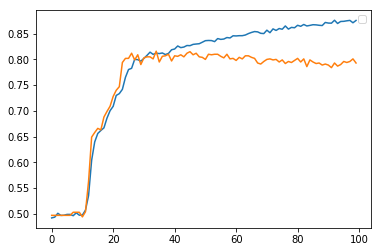

In [95]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend()

In [96]:
model.save('chatbotmodel.h5')

In [97]:
pred_result = model.predict(([input_test,question_test]))

In [98]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [100]:
pred_result.shape

(1000, 38)

In [101]:
pred_result[0]

array([1.53493822e-14, 1.41967237e-14, 1.43516113e-14, 1.46084842e-14,
       1.47556138e-14, 1.36015738e-14, 1.41527372e-14, 1.47915703e-14,
       1.45014920e-14, 1.39592546e-14, 1.52667524e-14, 1.39803567e-14,
       1.49672992e-14, 1.53901601e-14, 1.27283861e-14, 1.35278895e-14,
       1.36318840e-14, 1.36532470e-14, 1.34680314e-14, 1.45987060e-14,
       1.18159453e-14, 1.34934864e-14, 1.44929201e-14, 1.41734294e-14,
       1.32723863e-14, 1.30338601e-14, 1.39282701e-14, 1.52901543e-14,
       1.38276045e-14, 1.23966169e-14, 1.49522898e-14, 1.54712160e-14,
       1.38880013e-14, 1.29135492e-14, 1.53790385e-14, 1.33208518e-14,
       9.98858094e-01, 1.14195724e-03], dtype=float32)

In [102]:
val_max = np.argmax(pred_result[0])

In [103]:
val_max

36

In [104]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [105]:
k

'no'

In [106]:
pred_result[0][val_max]

0.9988581

In [107]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [108]:
my_story = 'John left the kitchen . Sandra dropped the football in the garden .'

In [109]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [110]:
my_question = 'Is the football in the garden ?'

In [111]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [117]:
my_data = [[my_story.split(),my_question.split(),'yes']]

In [118]:
my_data

[[['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes']]

In [119]:
my_story, my_question, my_answer = vectorize_stories(my_data)

In [120]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,
        32,  2, 15,  1,  5, 29,  2, 21, 34,  2, 18,  1]])

In [121]:
pred_result = model.predict(([my_story,my_question]))

In [122]:
val_max = np.argmax(pred_result[0])

In [123]:
val_max

37

In [124]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [125]:
k

'yes'

In [126]:
pred_result[0][val_max]

0.72423255